In [51]:
import numpy as np
import pandas as pa
import pickle
import librosa.display

from src.utils import get_framed_label, train_test_split
from src.data import load_annotation
from src.data import load_radar, load_water_distance, load_weight_sensor, load_audio
from src import make_dataset

from matplotlib import pyplot as plt

with open('rf-extended-defecate-0121.pkl', 'rb') as f:
    model = pickle.load(f)

In [2]:
config = {
    'USE_IDS': [],
    'DATAFRAME_PATH': "C:/Users/Jiajun/Desktop/download-project/data/raw/data_frames",
    'ANNOTATION_PATH': "C:/Users/Jiajun/Desktop/download-project/data/processed/Annotation.csv",
    'FEATURE_NAMES': ['Max', 'Min', 'Mean', 'Median', 'LogVariance', 'LinearTrend'],
    'SOURCE_NAMES': ['TotalWeight', 'RadarSum', 'AudioDelay4'],
    'WINDOW_SECONDS': 2,
    'HOP_SECONDS': 1,
    'CATEGORY': "Defecation",
}

complete_ids = load_annotation.get_complete_ids(
    annotation_filename = config['ANNOTATION_PATH'],
    category = config['CATEGORY']
)

annotations = load_annotation.get_annotation(config['ANNOTATION_PATH'])

In [54]:
def get_annotated_intervals(use_i, category='Defecation'):
    try:
        annotated_intervals = annotations[use_i]
        ans = []
        for interval in annotated_intervals:
            if interval[2] == category:
                ans.append(interval[:2])
        return ans
    except:
        print(f'use_i {use_i} is not annotated!')
        raise

def from_boolean_array_to_intervals(boolean_array):
    intervals = []
    start = 0
    while start < len(boolean_array):
        while start < len(boolean_array) and boolean_array[start] == 0:
            start += 1
        end = start
        while end < len(boolean_array) and boolean_array[end] == 1:
            end += 1
        if end > start:
            intervals.append([start, end-1])
        start = end + 1
    
    return intervals


def get_predicted_intervals(use_i, category='Defecation'):
    pred_config = config.copy()
    pred_config['USE_IDS'] = [use_i]
    pred_config['CATEGORY'] = category
    
    dataset = make_dataset.RandomForestExtended(pred_config)
    x, y = dataset.get_features_and_labels_from_users()
    ypred = model.predict(x)
    pred_intervals = from_boolean_array_to_intervals(ypred)
    return pred_intervals
    

def plot_func(use_i, category='Defecation'):
    # get annotated time intervals for category
    intervals = get_annotated_intervals(use_i, category)
    pred_intervals = get_predicted_intervals(use_i, category)
    
    # get sensors
    sensors = {
        'TotalWeight': load_weight_sensor.get_total_weight_clean(use_i),
        'RadarSum': load_radar.get_radar_sum_clean(use_i),
        'AudioDelay4': load_audio.get_audio_delay4_clean(use_i)
    }
    limits = {
        'TotalWeight': [sensors['TotalWeight'].median()-1, sensors['TotalWeight'].median()+1],
        'RadarSum': None,
        'AudioDelay4': None
    }
    
    fig, axes = plt.subplots(nrows=len(sensors)+1, ncols=1, sharex=True, figsize=(10, 2*len(sensors)+2))
    for ax, (sensor_name, sensor_data) in zip(axes, sensors.items()):
        ax.plot(sensor_data)
        ax.title.set_text(f'{sensor_name}')
        ax.set_ylim(limits[sensor_name])
        ax.xaxis.set_major_formatter(librosa.display.TimeFormatter())
        # annotation region
        for interval in intervals:
            ax.axvspan(interval[0], interval[1], color="orange")
    
    axes[len(sensors)].plot(sensors['RadarSum'])
    for interval in pred_intervals:
        axes[len(sensors)].axvspan(interval[0], interval[1], color="red")

    plt.suptitle(f'{use_i}')
    plt.tight_layout()
    plt.savefig(f'rf-extended-diagonstic-0121-{use_i}.pdf')
    plt.show()

updating 1854


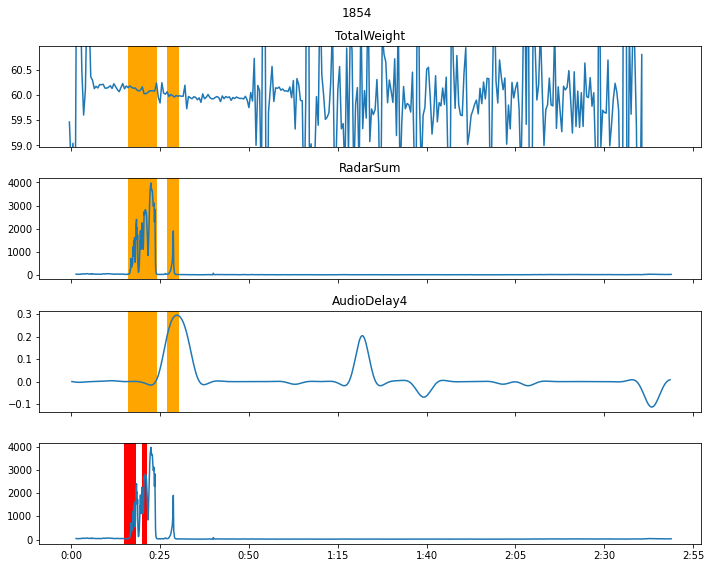

updating 1870


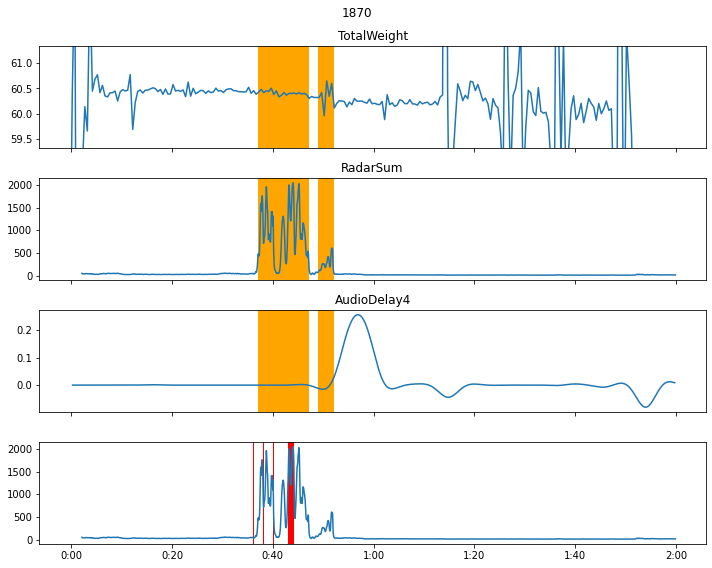

updating 1875


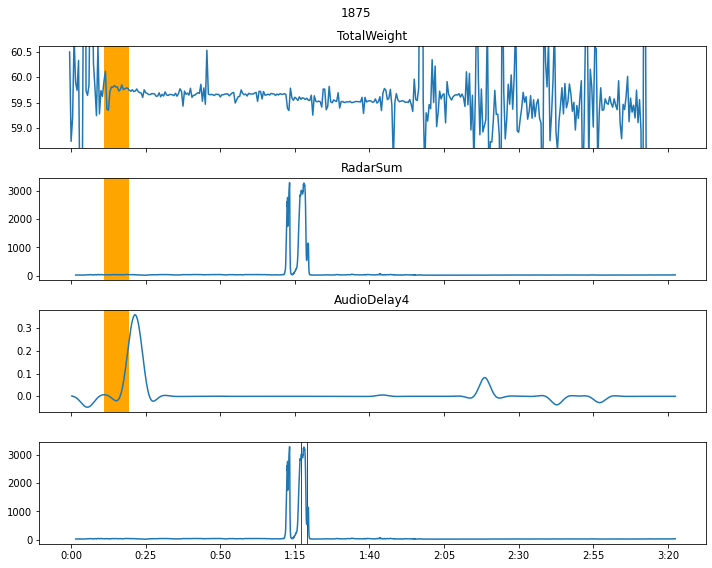

updating 1882


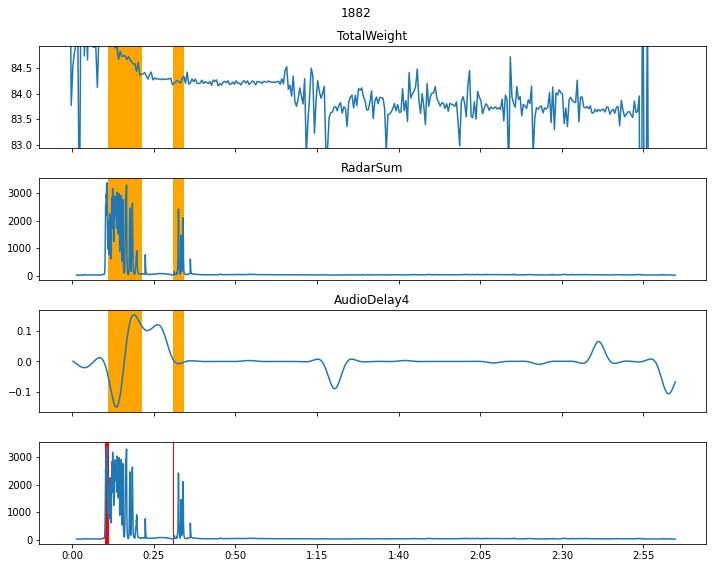

updating 1890


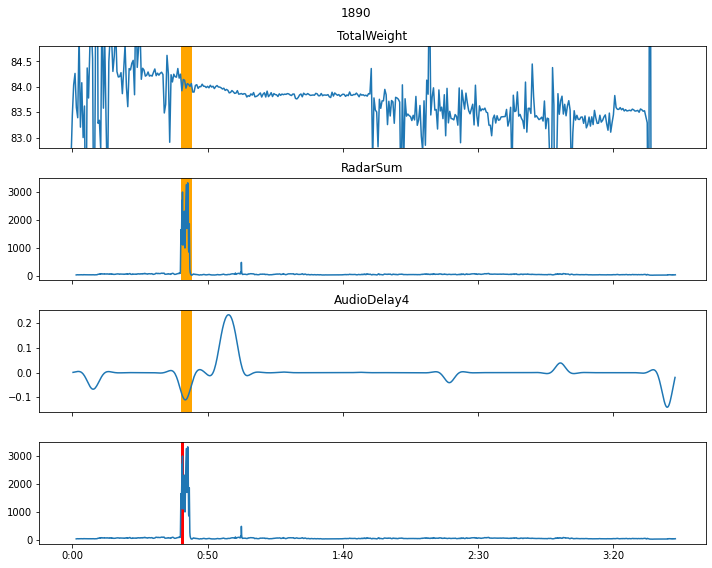

In [55]:
for use_i in [1854, 1870, 1875, 1882, 1890]:
    plot_func(use_i)